In [1]:
import xugrid as xu
import functools as ft
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp

In [2]:
ds = xu.open_dataset('data/icon_grid_0013_R02B04_R_ugrid.nc')
global_grid = ds.ugrid.grid
print(f"loaded dataset {type(ds)}")
print(f"loaded dataset {type(ds.ugrid)}")

print("---------------------------")
print(f" ---- dimensions of entire dataset: {ds.dims}")
print("---------------------------")
print(" ---- grid property: ")
print(f" ---- type of accessor's grid: ugrid.grid {type(global_grid)}")
print(f" ---- grid: {global_grid}")

loaded dataset <class 'xugrid.core.wrap.UgridDataset'>
loaded dataset <class 'xugrid.core.dataset_accessor.UgridDatasetAccessor'>
---------------------------
 ---- dimensions of entire dataset: FrozenMappingWarningOnValuesAccess({'cell': 20480, 'nv': 3, 'vertex': 10242, 'ne': 6, 'edge': 30720, 'no': 4, 'nc': 2, 'two_grf': 2, 'cell_grf': 14, 'max_chdom': 1, 'edge_grf': 24, 'vert_grf': 13, 'vert_delaunay': 3, 'cell_delaunay': 40956})
---------------------------
 ---- grid property: 
 ---- type of accessor's grid: ugrid.grid <class 'xugrid.ugrid.ugrid2d.Ugrid2d'>
 ---- grid: <xarray.Dataset> Size: 3MB
Dimensions:                (cell: 20480, nv: 3, edge: 30720, nc: 2,
                            vertex: 10242)
Coordinates:
    vlon                   (vertex) float64 82kB ...
    vlat                   (vertex) float64 82kB ...
    clon                   (cell) float64 164kB ...
    clat                   (cell) float64 164kB ...
    elon                   (edge) float64 246kB ...
    elat

/home/magdalena/Projects/exclaim/icon4py/.venv/lib/python3.10/site-packages/xugrid/ugrid/conventions.py:203: UserWarning: No standard_name of ('projection_x_coordinate', 'longitude', 'projection_y_coordinate', 'latitude') in ['vlon', 'vlat'].
Using vlon and vlat as projected x and y coordinates.
  warnings.warn(
/home/magdalena/Projects/exclaim/icon4py/.venv/lib/python3.10/site-packages/xugrid/ugrid/conventions.py:203: UserWarning: No standard_name of ('projection_x_coordinate', 'longitude', 'projection_y_coordinate', 'latitude') in ['clon', 'clat'].
Using clon and clat as projected x and y coordinates.
  warnings.warn(
/home/magdalena/Projects/exclaim/icon4py/.venv/lib/python3.10/site-packages/xugrid/ugrid/conventions.py:203: UserWarning: No standard_name of ('projection_x_coordinate', 'longitude', 'projection_y_coordinate', 'latitude') in ['elon', 'elat'].
Using elon and elat as projected x and y coordinates.
  warnings.warn(


# inspecting connectivities
c2e2c is a scipy.sparse matrix with dim (n_cell x n_cell)
where as e2c and c2e are full matrices of sparse size as we use them

In [3]:
global_c2e2c = global_grid.face_face_connectivity
print(f"global grid - c2e2c {global_c2e2c.shape}")
global_c2e = global_grid.face_edge_connectivity
print(f"global grid - c2e {global_c2e.shape}") 
global_e2c = global_grid.edge_face_connectivity
print(f" global grid e2c {global_e2c.shape }")




global grid - c2e2c (20480, 20480)
global grid - c2e (20480, 3)
 global grid e2c (30720, 2)


In [4]:
# global cell index 
cell_index = ds.cell_index
cell_index

<xarray.DataArray 'cell_index' (cell: 20480)> Size: 82kB
[20480 values with dtype=int32]
Coordinates:
    clon     (cell) float64 164kB ...
    clat     (cell) float64 164kB ...
  * cell     (cell) int64 164kB 0 1 2 3 4 5 ... 20475 20476 20477 20478 20479
Attributes:
    long_name:  cell index
    cdi:        ignore

<xarray.DataArray 'labels' (cell: 20480)> Size: 164kB
array([3, 0, 0, ..., 2, 2, 2])
Coordinates:
  * cell     (cell) int64 164kB 0 1 2 3 4 5 ... 20475 20476 20477 20478 20479

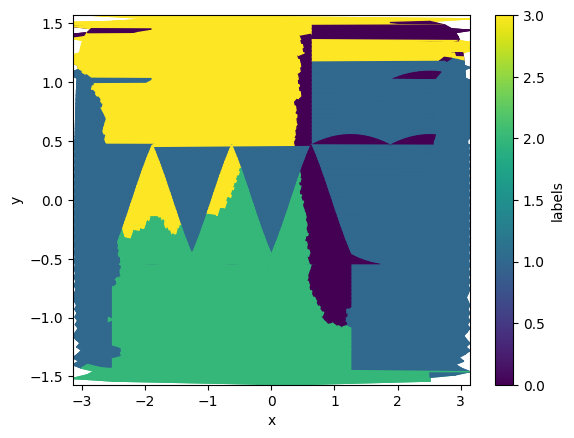

In [5]:
# get partitioning labels
# returns an array which maps each cell to a partion number from [0, n_part-1]

labels = ds.ugrid.grid.label_partitions(n_part=4)
labels.ugrid.plot()
labels


In [6]:
#partition the grid with xugrid using previousely defined labels
import xugrid.ugrid.partitioning as part

cells = ds.cell_index.to_dataset()
print(type(cells))
#patches = part.partition_by_label(global_grid, cells,   labels)

<class 'xugrid.core.wrap.UgridDataset'>


In [7]:
#define an rank to experiment with out of [0.. npatch-1]
rank = 0

c_owned_by_rank_mask = labels.data == rank
owned_global_cells = np.asarray(c_owned_by_rank_mask).nonzero()[0]
print(f"number of cells on rank = {rank} : {owned_global_cells.shape}")




number of cells on rank = 0 : (5120,)


In [8]:
# reduce connectivity array to the local grid
local_face_edge_connectivity = global_grid.face_edge_connectivity[owned_global_cells, :]
print(f"e2c connectivity on rank ={0} has size = {local_face_edge_connectivity.shape}")
# target indices are in the global grid, the might run up to n_edge of the global grid 
# TODO we eventually need to do a conversion of global_to_local_index
# but first we need to construct the halos
local_face_edge_connectivity

e2c connectivity on rank =0 has size = (5120, 3)


array([[    3,     4,     5],
       [    6,     1,     5],
       [    6,     7,     8],
       ...,
       [30354, 30357, 29614],
       [30352, 29362, 30358],
       [30359, 30357, 30358]])

## halo construction

we start with the distributed cells and use c2e2c connectivity to find the halo cell lines
We do 2 lines as ICON does, but I think it could easily changed to add n cell halo lines

In [9]:
def next_halo_line(cell_line, depot = None):
    # as seen above c2e2c is a scipy spars matrix in xugrid so we reduce it to the foramt we use 
    x, y, val = sp.sparse.find(global_c2e2c[cell_line, :])
    
    #check that each row index occurs 3 times
    #assert x.shape[0] / 3 == np.unique(x).shape[0] 

    
    #next_halo_size = np.unique(y).shape[0] - cell_line.shape[0]
    #print(f"expected number of halo cells in next lineline {next_halo_size}")
    # figure out the global indices of next line 
    if depot is not None: 
        cells_so_far = np.hstack((depot, cell_line)) 
    else:
        cells_so_far = cell_line
    
    next_halo_cells = np.setdiff1d(np.unique(y),cells_so_far, assume_unique=True)
    #assert next_halo_cells.shape[0] == next_halo_size
    return next_halo_cells
    

In [10]:
# construct first halo line
##  

first_halo_cells = next_halo_line(owned_global_cells)
print(f"number of cells in first halo line {first_halo_cells.shape[0]}")


number of cells in first halo line 180


In [11]:
#construct second halo line: 
# get the neighbor cells of the first halo line: #

second_halo_cells = next_halo_line(first_halo_cells, owned_global_cells)

print(f"number of celss in second halo line {second_halo_cells.shape}")



number of celss in second halo line (181,)


In [12]:
# build up decomposition_info for cells: it needs an array of local (owned + halo) global indices and an owner_mask of local indices
from icon4py.model.common.decomposition import definitions as decomp
import icon4py.model.common.dimension as dims
total_halo_cells = np.hstack((first_halo_cells, second_halo_cells))
global_cell_index = np.hstack((owned_global_cells, total_halo_cells)) 

c_owner_mask = np.isin(global_cell_index, owned_global_cells)
c_owner_mask.shape
decomp_info = decomp.DecompositionInfo(klevels = 10).with_dimension(dims.CellDim, global_cell_index, c_owner_mask)


Create what is call `decom_domain` in `t_decomposition_info` in `mo_decomposition_tools.f90`:
- A value of 0 means the cell is owned
- A value of 1 means the cell is in the first halo line: it has an edge shared with an owned cell
- A value of 2 means the cell is in the second halo line: it has a vertex shared with an owned cell and edges shared with cells from halo line 1
- 

In [13]:
decomp_domain_cells = np.zeros_like(global_cell_index)
decomp_domain_cells = np.where(np.isin(global_cell_index, first_halo_cells), 1, decomp_domain_cells)
decomp_domain_cells = np.where(np.isin(global_cell_index, second_halo_cells),2, decomp_domain_cells)
decomp_domain_cells


array([0, 0, 0, ..., 2, 2, 2])

## start and end index arrays for domain bounds
Construct the `start_index` and `end_index` for cells. It should be constructed from the `refin_ctrl` value for the owned cells the halo start and end indices
can be taken from the `decomp_domain_cells` above


In [14]:
refin_ctrl = ds.refin_c_ctrl[global_cell_index]
#global start_idx for cells

ds.start_idx_c.data
ds.end_idx_c.data


array([[20479, 20479, 20479, 20479, 20479,    -1,    -1,    -1,    -1,
           -1,    -1,    -1,    -1,    -1]], dtype=int32)

In [15]:
import icon4py.model.common.grid.horizontal as hgrid
start_index = np.zeros_like(np.squeeze(ds.start_idx_c.data))
end_index = np.zeros_like(np.squeeze(ds.end_idx_c.data))
num_cells = global_cell_index.shape[0]
#the following only works for global grid, in the limited area case we need to look at the refin_ctrl values
# not really need to check indices!!!

# maybe refin_c_ctrl should be used in the first place for this.

# I never uderstood this (from the Dusk/Down nomenclature
start_index[hgrid.HorizontalMarkerIndex.end(dims.CellDim)] = 0
end_index[hgrid.HorizontalMarkerIndex.end(dims.CellDim)] = num_cells



start_index[hgrid.HorizontalMarkerIndex.lateral_boundary(dims.CellDim)] = num_cells
end_index[hgrid.HorizontalMarkerIndex.lateral_boundary(dims.CellDim)] = num_cells

start_index[hgrid.HorizontalMarkerIndex.nudging(dims.CellDim)] = num_cells
end_index[hgrid.HorizontalMarkerIndex.nudging(dims.CellDim)] = num_cells

start_index[hgrid.HorizontalMarkerIndex.interior(dims.CellDim)] = 0
end_index[hgrid.HorizontalMarkerIndex.interior(dims.CellDim)] = num_cells

# there is something wrong, there need to be 2 halo lines, so halo and halo + 1 should be filled
start_index[hgrid.HorizontalMarkerIndex.local(dims.CellDim)] = 0
end_index[hgrid.HorizontalMarkerIndex.local(dims.CellDim)] = np.argmax(decomp_domain_cells == 1)

start_index[hgrid.HorizontalMarkerIndex.halo(dims.CellDim)] = np.argmax(decomp_domain_cells == 1)
end_index[hgrid.HorizontalMarkerIndex.halo(dims.CellDim)] = np.argmax(decomp_domain_cells == 2)

start_index[hgrid.HorizontalMarkerIndex.halo(dims.CellDim) + 1] = np.argmax(decomp_domain_cells == 2)
end_index[hgrid.HorizontalMarkerIndex.halo(dims.CellDim) + 1] = num_cells



print(f"0    1 2 3    4     5 6 7 8        9  10 11 12 13")
print(f"end  - - halo local - - - interior lb -  -  -  nudging  ")
print(f"start index: {start_index}")
print(f"end   index: {end_index}")



0    1 2 3    4     5 6 7 8        9  10 11 12 13
end  - - halo local - - - interior lb -  -  -  nudging  
start index: [   0    0    0 5120 5300    0    0    0    0 5481    0    0    0 5481]
end   index: [5481    0    0 5300 5481    0    0    0 5481 5481    0    0    0 5481]


## Edges

Construct halos and decomposition_info for edges.


In [16]:

def find_edges_for_cells(cells_array):
    """ get all (unique) edges connected to a given array of cells. working on global indices"""
    connected_edges = global_grid.face_edge_connectivity[cells_array, :]
    shp = connected_edges.shape
    unique_edges = np.unique(connected_edges.reshape(shp[0] * shp[1]))
    return unique_edges                  





In [17]:
# find all edges on owned cells
edges_on_owned_cells = find_edges_for_cells(owned_global_cells)
print(f"number of edges on owned cells {edges_on_owned_cells.shape}")



number of edges on owned cells (7770,)


In [18]:
# find edges on the first halo line
edges_on_first_halo_line = find_edges_for_cells(first_halo_cells)
print(f"number of edges on first_halo_cells {edges_on_first_halo_line.shape}")


number of edges on first_halo_cells (500,)


In [19]:
# edges on the secon halo line
edges_on_second_halo_line = find_edges_for_cells(second_halo_cells)
print(f"number of edges on the second cell halo line{edges_on_second_halo_line.shape}")

number of edges on the second cell halo line(503,)


we need to reduce the overlaps:
- `edges_on_owned_cells` and `edges_on_first_halo_line` contain the edges on the cutting line. In order to construct the owned edges these will be owned by either of the adjacent nodes, this is a convention on where they go.
So in terms of `decomp_domain`for edges they go to `0` for one node and to `1` for the other.



In [20]:

#over lap of owned edges and first halo line edges

## those are the edges with a decomp_domain = 1  or decomp_domain = 0 depending on whether they
## are owned by this rank or by the neighbor rank
## need to decide by a convention on which rank they are owned. Afaik ICON adopts a convention to put them on the 
## node with the _larger_ (or smaller) rank. So obviousely depending on who the neighbor is some of them here might have decomp_domain == 1 and others decomp_domain == 0
intersect_owned_first_line = np.intersect1d(edges_on_owned_cells, edges_on_first_halo_line)

# there is one such edge per first halo line cell
assert intersect_owned_first_line.shape == first_halo_cells.shape


# edges with decomp_domain = 2 : share 1 vertex with owned cell
intersect_first_second_line = np.intersect1d(edges_on_first_halo_line, edges_on_second_halo_line)

# "closing" edges of second halo line. They have no connection to the first halo line, in fact they are parallel to the cutting line.
# decomp_domain has no category for them. I suspect that they are not present in ICON because they are not used. That would mean that the second 
# halo cell line remains open
# are they not present on the node? maybe they are not needed? Because no connectivity no c2e is done on the second halo cell line?
# the are probably not present in ICON there is no category for them. We will add them with decom_domain=0

closing_edges_on_second_line = np.setdiff1d(edges_on_second_halo_line, edges_on_first_halo_line, assume_unique=True)
# there should be one such egde per cell in the second halo line 
# but in FACT there is not!! WHY? Because of "corners"??
# assert closing_edges_on_second_line.shape  == second_halo_cells.shape
closing_edges_on_second_line.shape



(224,)

In [21]:
# add edges to decomp_info for edges adn decomp_domain for edges.
# construct for a rank that owns the limiting cells

# For this example lets put the cutting line edges  _not_ to this rank
owned_edges = np.setdiff1d(edges_on_owned_cells, edges_on_first_halo_line)

total_edges_on_rank = np.hstack((owned_edges, intersect_owned_first_line, intersect_first_second_line, closing_edges_on_second_line))
e_owner_mask = np.isin(total_edges_on_rank, owned_edges)


decomp_info.with_dimension(dims.EdgeDim, total_edges_on_rank, e_owner_mask)
decomp_domain_edges = np.zeros_like(total_edges_on_rank)

decomp_domain_edges = np.where(np.isin(total_edges_on_rank, intersect_owned_first_line), 1, decomp_domain_edges)
decomp_domain_edges = np.where(np.isin(total_edges_on_rank, intersect_first_second_line),2, decomp_domain_edges)
decomp_domain_edges = np.where(np.isin(total_edges_on_rank, closing_edges_on_second_line),3, decomp_domain_edges)

np.where(decomp_domain_edges == 1)

 

(array([7590, 7591, 7592, 7593, 7594, 7595, 7596, 7597, 7598, 7599, 7600,
        7601, 7602, 7603, 7604, 7605, 7606, 7607, 7608, 7609, 7610, 7611,
        7612, 7613, 7614, 7615, 7616, 7617, 7618, 7619, 7620, 7621, 7622,
        7623, 7624, 7625, 7626, 7627, 7628, 7629, 7630, 7631, 7632, 7633,
        7634, 7635, 7636, 7637, 7638, 7639, 7640, 7641, 7642, 7643, 7644,
        7645, 7646, 7647, 7648, 7649, 7650, 7651, 7652, 7653, 7654, 7655,
        7656, 7657, 7658, 7659, 7660, 7661, 7662, 7663, 7664, 7665, 7666,
        7667, 7668, 7669, 7670, 7671, 7672, 7673, 7674, 7675, 7676, 7677,
        7678, 7679, 7680, 7681, 7682, 7683, 7684, 7685, 7686, 7687, 7688,
        7689, 7690, 7691, 7692, 7693, 7694, 7695, 7696, 7697, 7698, 7699,
        7700, 7701, 7702, 7703, 7704, 7705, 7706, 7707, 7708, 7709, 7710,
        7711, 7712, 7713, 7714, 7715, 7716, 7717, 7718, 7719, 7720, 7721,
        7722, 7723, 7724, 7725, 7726, 7727, 7728, 7729, 7730, 7731, 7732,
        7733, 7734, 7735, 7736, 7737, 

## Vertices
Should the vertices be calculated based on cells as the edges? 
Calculation based on cells reduces the indirection as it goes back to the originally distributed dimension. 
For vertices there are the same categories in decomp_domain as there are for the edges: 
```
0 == owned
1 == not owned, but on an owned cell
2 == on a halo cell only
```
So in order to determine whether a vertex is of type `1` or `0` it is best to look at what the edges are. If an `decomp_domain(e) == 1` then `decomp_domain(e2v) == 1` for both edges. 

Having 2 cell halo lines as ICON has it there are no new edges introduced in the second halo line. `C2V` for owned cells contains all category `1` and `0` vertices and `C2V(first_halo_line) contains all category = `1` and `2 vertices.



In [44]:


def find_vertices_for_cells(cell_line):
    connected_vertices = global_grid.face_node_connectivity[cell_line, :]
    shp = connected_vertices.shape
    unique_vertices = np.unique(connected_vertices.reshape(shp[0] * shp[1]))
    return unique_vertices             
    
        
vertices_on_owned_cells = find_vertices_for_cells(owned_global_cells)

vertices_on_first_halo_line = find_vertices_for_cells(first_halo_cells)



#outer vertices on halo line
vertices_on_halo_cells = np.setdiff1d(vertices_on_first_halo_line, vertices_on_owned_cells)



# all owned vertices are on owned edges
vertices_on_owned_edges = np.unique(global_grid.edge_node_connectivity[owned_edges])
# they are a subset of the vertices on owned cells
assert np.all(np.isin(vertices_on_owned_edges, vertices_on_owned_cells))


# category 1 vertices
halo_vertices_on_owned_cells = np.setdiff1d(vertices_on_owned_cells, vertices_on_owned_edges)




# create decomposition_info
total_vertices_on_rank = np.hstack((vertices_on_owned_cells, vertices_on_halo_cells))
# ordering by decomp.domain
v_owner_mask = np.isin(total_vertices_on_rank, vertices_on_owned_edges)


decomp_info.with_dimension(dims.VertexDim, total_edges_on_rank, v_owner_mask)

# decomp_domain info
# only category 2 vertices
decomp_domain_vertices = np.zeros_like(total_vertices_on_rank)

decomp_domain_vertices = np.where(np.isin(total_vertices_on_rank, intersect_owned_first_line), 1, decomp_domain_edges)

decomp_domain_2_vertices = np.setdiff1d(vertices_on_first_halo_line, vertices_on_owned_cells)
decomp_domain_edges = np.where(decomp_domain_2_vertices,2, decomp_domain_edges)

